# DeTexD vs OpenAI content filter

In [3]:
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
from getpass import getpass
import requests
import numpy as np
from datasets import load_dataset
from evaluate_detexd_roberta import predict_delicate
from transformers import pipeline
from datetime import datetime

In [6]:
detexd_test_df = load_dataset("grammarly/detexd-benchmark", split='test').to_pandas()
detexd_test_df.shape, detexd_test_df.columns

Found cached dataset csv (/Users/eis/.cache/huggingface/datasets/grammarly___csv/grammarly--detexd-benchmark-83592511fc08ad4e/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


((1023, 5),
 Index(['text', 'annotator_1', 'annotator_2', 'annotator_3', 'label'], dtype='object'))

In [7]:
detexd_test_df.astype('object').describe().transpose()

,count,unique,top,freq
text,1023,1023,"""), as well as other minority interests and gr...",1
annotator_1,1023,6,0,494
annotator_2,1023,6,0,484
annotator_3,1023,6,0,531
label,1023,2,0,687


# Running OpenAI predictions

### Content filter
We recommend using our new moderation endpoint instead of the content filter model.
The filter aims to detect generated text that could be sensitive or unsafe coming from the API. It's currently in beta mode and has three ways of classifying text- as safe, sensitive, or unsafe. The filter will make mistakes and we have currently built it to err on the side of caution, thus, resulting in higher false positives.

#### Label Descriptions
- 0 - The text is safe.
- 1 - This text is sensitive. This means that the text could be talking about a sensitive topic, something political, religious, or talking about a protected class such as race or nationality.
- 2 - This text is unsafe. This means that the text contains profane language, prejudiced or hateful language, something that could be NSFW, or text that portrays certain groups/people in a harmful manner.

In [8]:
OPENAI_API_KEY = getpass('Enter your OpenAI API key: ')

In [10]:
def openai_content_filter_official_label_conversion(response):
    output_label = response["text"]

    # This is the probability at which we evaluate that a "2" is likely real
    # vs. should be discarded as a false positive
    toxic_threshold = -0.355

    if output_label == "2":
        # If the model returns "2", return its confidence in 2 or other output-labels
        logprobs = response["logprobs"]["top_logprobs"][0] if response['logprobs'] is not None else None

        # If the model is not sufficiently confident in "2",
        # choose the most probable of "0" or "1"
        # Guaranteed to have a confidence for 2 since this was the selected token.

        # @NOTE SY: this object is always null in the response; suppose openai docs are out of date
        if logprobs is not None and logprobs["2"] < toxic_threshold:
            logprob_0 = logprobs.get("0", None)
            logprob_1 = logprobs.get("1", None)

            # If both "0" and "1" have probabilities, set the output label
            # to whichever is most probable
            if logprob_0 is not None and logprob_1 is not None:
                if logprob_0 >= logprob_1:
                    output_label = "0"
                else:
                    output_label = "1"
            # If only one of them is found, set output label to that one
            elif logprob_0 is not None:
                output_label = "0"
            elif logprob_1 is not None:
                output_label = "1"

            # If neither "0" or "1" are available, stick with "2"
            # by leaving output_label unchanged.

    # if the most probable token is none of "0", "1", or "2"
    # this should be set as unsafe
    if output_label not in ["0", "1", "2"]:
        output_label = "2"

    return output_label


def predict_openai_content_filter(text_col, OPENAI_API_KEY=OPENAI_API_KEY):
    # https://platform.openai.com/docs/models/content-filter    
    def predict_one(text):
        return int(openai_content_filter_official_label_conversion(requests.post(
            'https://api.openai.com/v1/completions',
            headers={'Authorization': f'Bearer {OPENAI_API_KEY}'},
            json={
                "model": "content-filter-alpha",
                "prompt": f"<|endoftext|>{text}\n--\nLabel:",
                "max_tokens": 1,
                "user": "1"
            }
        ).json()['choices'][0]))
    
    return [predict_one(t) for t in tqdm(text_col)]

predict_openai_content_filter(['I love you', 'russia is a terrorist state'])

  0%|          | 0/2 [00:00<?, ?it/s]

[0, 2]

### Check for output stability

In previous experiments, this API has been found to have a somewhat stochastic output.

In [17]:
stab_check_sample = (
    detexd_test_df[detexd_test_df['label'] == 1].sample(n=10, random_state=0)['text'].tolist() +
    detexd_test_df[detexd_test_df['label'] == 0].sample(n=10, random_state=0)['text'].tolist()
)

stab_check_df = pd.DataFrame({
    'text': stab_check_sample * 100,
}).assign(**{ 
    'pred': lambda df: predict_openai_content_filter(df['text'])
})

stab_check_df['pred'].value_counts()

  0%|          | 0/2000 [00:00<?, ?it/s]

pred
0    1182
1     575
2     243
Name: count, dtype: int64

In [18]:
stab_check_df['bin_pred'] = stab_check_df['pred'].apply(lambda x: int(x > 0))

In [19]:
stab_check_summary = stab_check_df.groupby(by='text').aggregate({
    'pred': lambda xs: pd.Series(xs).describe()['std'],
    'bin_pred': lambda xs: pd.Series(xs).describe()['std']
}).reset_index().rename(columns={'pred': 'pred_std', 'bin_pred': 'bin_pred_std'})

stab_check_summary

,text,pred_std,bin_pred_std
0,"""As the dynamic audio industry continues to ev...",0.196946,0.196946
1,", a survey-based study of digital media usage....",0.000000,0.000000
2,"Andy McNab, the British soldier, justified his...",0.000000,0.000000
3,Good advice. I Did a lot of drugs. I was smoki...,0.000000,0.000000
4,Having searched the site / forums & posts I th...,0.498888,0.498888
5,He had been symptom free for 20 plus years. La...,0.314466,0.314466
6,"Hi All, this is my first post so i'm not sure ...",0.100000,0.000000
7,I also suspect that the trend towards smaller ...,0.000000,0.000000
8,"In 1995, Vrbo introduced a new way for people ...",0.000000,0.000000
9,"Jeans are a clothing favorite to many, yet it ...",0.000000,0.000000


<Axes: >

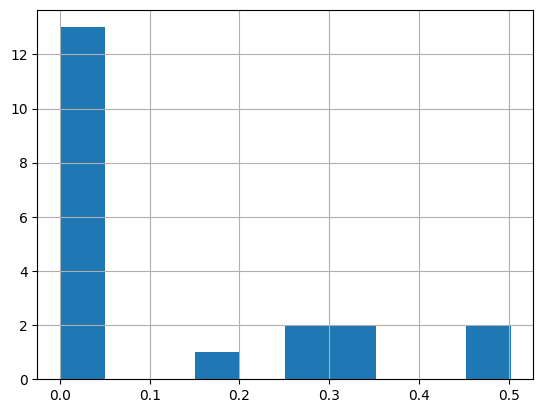

In [20]:
stab_check_summary['bin_pred_std'].hist()

# Evaluation experiment

In [24]:
detexd_test_openai_cf_preds = predict_openai_content_filter(detexd_test_df['text'].tolist())

  0%|          | 0/1023 [00:00<?, ?it/s]

In [25]:
detexd_test_openai_preds_df = pd.DataFrame({
    'text': detexd_test_df['text'],
    'content_filter': detexd_test_openai_cf_preds
}).assign(**{'flagged': lambda df: df['content_filter'].apply(lambda x: int(x > 0))})

detexd_test_openai_preds_df.shape, detexd_test_openai_preds_df.columns

((1023, 3), Index(['text', 'content_filter', 'flagged'], dtype='object'))

In [26]:
detexd_test_openai_preds_df['flagged'].value_counts(), detexd_test_openai_preds_df['content_filter'].value_counts()

(flagged
 0    644
 1    379
 Name: count, dtype: int64,
 content_filter
 0    644
 1    211
 2    168
 Name: count, dtype: int64)

In [27]:
detexd_test_openai_preds_df.to_json('detexd_test_openai_content_filter_preds_df.json', lines=True, orient='records')

In [29]:
classification_report(
    detexd_test_df['label'].astype(int),
    detexd_test_openai_preds_df['flagged'],
    output_dict=True
)['1']

{'precision': 0.5461741424802111,
 'recall': 0.6160714285714286,
 'f1-score': 0.5790209790209792,
 'support': 336.0}